In [1]:
!pip install pytelegrambotapi

In [2]:
import telebot
bot = telebot.TeleBot('1464758821:AAGrifrI392zaqR_5etgc9PU8Lm8yBvGXqI')

In [3]:
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import warnings

from PIL import Image

warnings.filterwarnings("ignore", category=UserWarning) 

In [4]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
!pip install -r pytorch-CycleGAN-and-pix2pix/requirements.txt
!bash pytorch-CycleGAN-and-pix2pix/scripts/download_cyclegan_model.sh summer2winter_yosemite

fatal: destination path 'pytorch-CycleGAN-and-pix2pix' already exists and is not an empty directory.
Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [summer2winter_yosemite]
for details.

--2021-02-14 12:51:13--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/summer2winter_yosemite.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/summer2winter_yosemite_pretrained/latest_net_G.pth’

./checkpoints/summe 100%[===================>]  43.46M  2.03MB/s    in

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):

    tensor = tensor.cpu().clone()  

    fig, ax = plt.subplots(1, tensor.shape[0], figsize=(12,12*tensor.shape[0]))
    
    if (tensor.shape[0] == 1):
        img = unloader(tensor[0])
        ax.imshow(img)
        if title is not None:
            ax.set_title(title[0])
    else:
        for index, img in enumerate(tensor):
            img = unloader(img)
            ax[index].imshow(img)
            if title is not None:
                ax[index].set_title(title[index])
    plt.pause(0.001) 

In [7]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [8]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [9]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()], lr = 0.1)
    return optimizer

In [10]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img, params = None, mode = "mix",
                                   mask = None, content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i = 0  
    for layer in cnn.children():
            
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
             
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)


        if name in style_layers:
            target_feature = model(style_img).detach()
            if mode == "mix":
                StyleLoss = StyleLoss_mix_styles
                style_loss = StyleLoss(target_feature, params)
            if mode == "sep":
                StyleLoss = StyleLoss_sep_styles
                style_loss = StyleLoss(target_feature, params, mask)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
        
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [11]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, params = None, mode = "mix", mask = None,
                        num_steps=500, style_weight=10000000, content_weight=1, show = True):
    """Run the style transfer."""
    if show is True:
        print('Building the style transfer model..')
        bot.send_message(globalVar["chat_id"], "Building the style transfer model..")  

    model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img, params, mode, mask)
        
    optimizer = get_input_optimizer(input_img)
    if show:
        print('Optimizing..')
        bot.send_message(globalVar["chat_id"], 'Optimizing..')  
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
                
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
                
            style_score *= style_weight
            content_score *= content_weight
                
            loss = style_score + content_score
            loss.backward()
                
            run[0] += 1
            if run[0] % 50 == 0 and show:

                if (globalVar["last_message"] is not None):
                    bot.delete_message(globalVar["chat_id"], message_id=globalVar["last_message"].message_id) 

                globalVar["last_message"] = bot.send_message(globalVar["chat_id"], "|"+"="*(run[0]//50-1)+">"+ \
                                                                    " "*((num_steps-run[0])//50)+"| %" + str(100*run[0]//num_steps))
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
                print()
                imshow(torch.cat([content_img, input_img], dim = 0), title=["Input Image", "Output Image"])

            return style_score.item() + content_score.item()

        optimizer.step(closure)
          
    input_img.data.clamp_(0, 1)

    return input_img

In [12]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach() 
        self.loss = F.mse_loss(self.target, self.target)

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [13]:
def gram_matrix_mix_styles(input, params = None):

    batch_size , f_map_num, h, w = input.size()
    G = 0
    if (params is None):
        params = torch.ones(len(input))
    for img, c in zip(input, params): 
        features = img.view(f_map_num, w * h) 
        G += torch.mm(features, features.t())*c         
                                                          
    G /= (batch_size * h * w * f_map_num)             
    return G 

In [14]:
class StyleLoss_mix_styles(nn.Module):
    def __init__(self, target_feature, params = None):
        super(StyleLoss_mix_styles, self).__init__()       
        self.target = gram_matrix_mix_styles(target_feature, params).detach()
        self.loss = F.mse_loss(self.target, self.target)# to initialize with something

    def forward(self, input, params = None):
        G = gram_matrix_mix_styles(input, params)
        self.loss = F.mse_loss(G, self.target)
        return input

In [15]:
def gram_matrix_sep_styles(input):

    batch_size, f_map_num, h, w = input.size()  
    features = input.view(f_map_num, w * h) 
    G = torch.mm(features, features.t())  
    G /= (batch_size * h * w * f_map_num)
    return G

In [16]:
class StyleLoss_sep_styles(nn.Module):
    def __init__(self, target_feature, params = None, mask = None):
        super(StyleLoss_sep_styles, self).__init__()   
        self.target_feature = target_feature
        self.target = torch.zeros((len(target_feature),target_feature.shape[1],target_feature.shape[1])).to(device)
        self.loss = F.mse_loss(self.target[0], self.target[0])# to initialize with something
        self.params = params
        self.mask = mask

    def forward(self, input):
        if len(input) == 1:
            separation = int(input.shape[3]/len(self.target_feature))
            self.loss = 0
            G = torch.zeros((len(self.target_feature), self.target_feature.shape[1], self.target_feature.shape[1])).to(device)
            for index, img in enumerate(self.target_feature):
                temp = torch.zeros_like(input)
                if self.mask is None:
                    temp[0, :, :, separation*index:separation*(index+1)] = 1
                else:
                    imsize = (input.shape[2], input.shape[3])
                    loader = transforms.Compose([
                                              transforms.Resize(imsize),
                                              transforms.ToTensor(),
                                              ]) 
                    if index<len(self.mask):
                        image = Image.open(self.mask[index])
                        image = loader(image)
                        image = image.unsqueeze(0)
                        temp[0, :] = image[0, 0]
                    else:
                        def mask_reverse (mask):
                            return torch.abs(mask-1)
                        image = Image.open(self.mask[-1])
                        image = loader(image)
                        image = image.unsqueeze(0)
                        temp[0, :] = mask_reverse(image)[0,0]

                self.target[index] = gram_matrix_sep_styles(img.unsqueeze(0)*temp).detach()
                G[index] = gram_matrix_sep_styles(input*temp)

            if (self.params is None):
                self.params = torch.ones(len(G))

            for g, t, p in zip(G, self.target, self.params): 
                self.loss += F.mse_loss(g, t)*p

        return input

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 396.911041 Content Loss: 7.286151



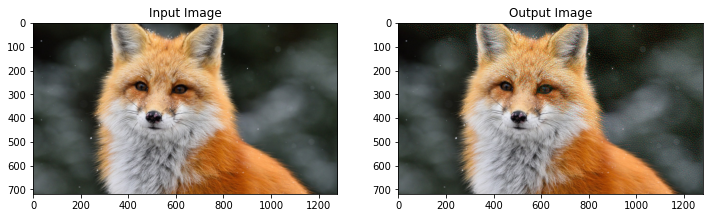

run [100]:
Style Loss : 31.430405 Content Loss: 10.524624



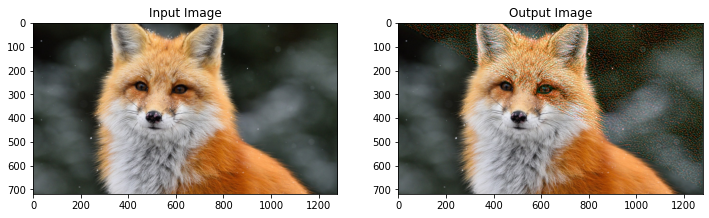

run [150]:
Style Loss : 8.801679 Content Loss: 10.803823



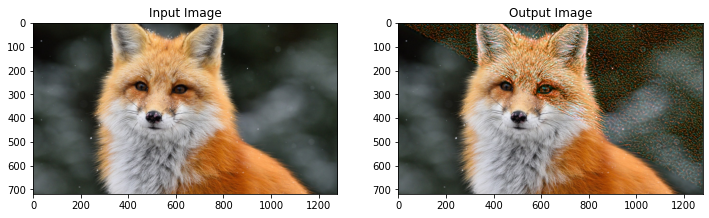

run [200]:
Style Loss : 4.380229 Content Loss: 10.610903



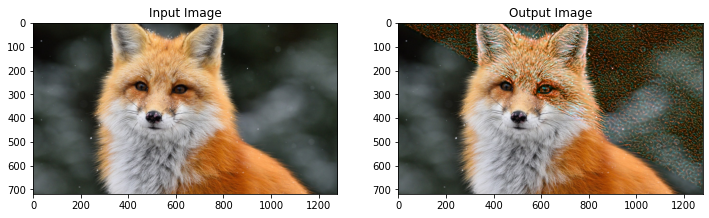

In [18]:
bot = telebot.TeleBot('1464758821:AAGrifrI392zaqR_5etgc9PU8Lm8yBvGXqI')

import os 
import time
import random
from telebot import types

globalVar= {
  "chat_id":None,
  "last_message":None,
  "add_content":True,
  "content_img":None,
  "mode":"MixStyles", 
  "style_img":[],
  "current_styles":[],
  "use_style":False,
  "choose_style":False,
  "loader":None,
  "current_mask":None,
  "use_mask":False,
  "choose_style":False,
}

def image_loader(image_name):
        image = Image.open(image_name)
        image = globalVar["loader"](image)
        image = image.unsqueeze(0)
        return image.to(device, torch.float)

@bot.message_handler(commands=['start'])
def start_message(message):
    globalVar["chat_id"] = message.chat.id
    bot.send_message(message.chat.id, 'Привет, для начала загрузите изображение для обработки')
    
@bot.message_handler(content_types=['text'])
def get_text_messages(message):
    if globalVar["add_content"] is True:
        bot.send_message(message.chat.id, text='Для начала загрузите изображение для обработки')
        return 
    if message.text.lower() == 'select mode':        
        markup = types.InlineKeyboardMarkup()
        item1 = types.InlineKeyboardButton("Mix Styles", callback_data='mix')
        item2 = types.InlineKeyboardButton("Separate Styles", callback_data='sep')
        item3 = types.InlineKeyboardButton("Summer to winter", callback_data='sum2wint')
        markup.add(item1, item2, item3)
        bot.send_message(message.chat.id, text='Выберите режим работы:', reply_markup=markup)
    elif message.text.lower() == 'view styles':
        bot.send_message(message.chat.id, 'Доступные стили:')
        bot.send_photo(message.chat.id, photo=Image.open("/content/drive/MyDrive/NSTTelebot/all_styles.jpg"))
    elif message.text.lower() == 'use style':
        markup = types.InlineKeyboardMarkup()
        item1 = types.InlineKeyboardButton("Our collection", callback_data='collection_style')
        item2 = types.InlineKeyboardButton("Random (from collection)", callback_data='random_style')
        item3 = types.InlineKeyboardButton("Custom style", callback_data='user_style')
        markup.add(item1, item2, item3)
        bot.send_message(message.chat.id, text='Вы можете использовать предложенные стили или загрузить свой:', reply_markup=markup)
    elif message.text.lower() == 'use mask':
        markup = types.InlineKeyboardMarkup()
        item1 = types.InlineKeyboardButton("Our collection", callback_data='collection_mask')
        item2 = types.InlineKeyboardButton("Random (from collection)", callback_data='random_mask')
        item3 = types.InlineKeyboardButton("Custom mask", callback_data='user_mask')
        item4 = types.InlineKeyboardButton("Off", callback_data='off_mask')
        markup.add(item1, item2, item3, item4)
        bot.send_message(message.chat.id, text='Вы можете использовать предложенные маски или загрузить свою (Маски будут работать только в режиме Separate Styles):', reply_markup=markup)
    elif message.text.lower() == 'change image':
        globalVar["add_content"] = True
        globalVar["use_style"] = False
        globalVar["use_mask"] = False
        bot.send_message(message.chat.id, "Загрузите новое изображение для обработки")
    elif message.text.isnumeric() and globalVar['choose_style'] is True:
        if (int(message.text)<=0 or int(message.text)>len(globalVar["style_img"])):
            bot.send_message(message.chat.id, 'Не удалось выбрать стиль, введите числот от 1 до '+str(len(globalVar["style_img"])))
        else:
            globalVar["current_styles"].append(globalVar["style_img"][int(message.text)-1])
            bot.send_message(message.chat.id, "Стиль №"+str(int(message.text))+" успешно выбран")
            globalVar["choose_style"] = False

    elif message.text.isnumeric() and globalVar['choose_mask'] is True:
        if (int(message.text)<=0 or int(message.text)>12):
            bot.send_message(message.chat.id, 'Не удалось выбрать макску, введите числот от 1 до '+str(len(globalVar["mask_img"])))
        else:
            if int(message.text)>=10:
                globalVar["current_mask"] = ["/content/drive/MyDrive/NSTTelebot/masks/mask_"+message.text+".jpg"]
            else:
                globalVar["current_mask"] = ["/content/drive/MyDrive/NSTTelebot/masks/mask_0"+message.text+".jpg"]
            bot.send_message(message.chat.id, "Маска №"+str(int(message.text))+" успешно выбрана")
            globalVar["choose_mask"] = False

    elif message.text.lower() == 'start processing':
        if (globalVar["mode"] != "sum2wint"):
            if len(globalVar["current_styles"])==0:
                bot.send_message(message.chat.id, text='Необходимо использовать хотя бы 1 стиль для обработки')
                return

            input_img = globalVar["content_img"].clone() 
            if (input_img.shape[2] > 600 or input_img.shape[3] > 600):
                style_weight = 10000000
            else:
                style_weight = 1000000
  
            if (len(globalVar["current_styles"])>1):
                style_img = torch.stack(globalVar["current_styles"]).squeeze(1)
            else:
                style_img = globalVar["current_styles"][0]

        if (globalVar["mode"] == "mix"):
            output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                globalVar["content_img"], style_img, input_img, num_steps = 1000, style_weight = style_weight)
            output_img = unloader(output.cpu().clone()[0])
        elif (globalVar["mode"] == "sep"):
            if (globalVar["current_mask"] is None):
                output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                    globalVar["content_img"], style_img, input_img, num_steps = 1000, mode = "sep", style_weight = style_weight, mask = globalVar["current_mask"])
            else:
                output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                    globalVar["content_img"], style_img, input_img, num_steps = 500, mode = "sep", style_weight = style_weight, mask = globalVar["current_mask"])
            output_img = unloader(output.cpu().clone()[0])
        elif (globalVar["mode"] == "sum2wint"):
            !mkdir image
            !cp "/content/image.jpg" "/content/image/"
            !python pytorch-CycleGAN-and-pix2pix/test.py --dataroot image --name summer2winter_yosemite_pretrained --model test --no_dropout
            output_img = Image.open("results/summer2winter_yosemite_pretrained/test_latest/images/image_fake.png")
            
        bot.send_photo(message.chat.id, photo=output_img)
        
        globalVar["current_styles"] = []
        globalVar["mask"] = None
        globalVar["last_message"] = None
    
@bot.message_handler(content_types=['photo'])
def get_photo(message):
    
    fileID = message.photo[-1].file_id
    file_info = bot.get_file(fileID)
    downloaded_file = bot.download_file(file_info.file_path)

    with open("image.jpg", 'wb') as new_file:
        new_file.write(downloaded_file)
            
    if globalVar["add_content"] is True:

        width = message.photo[-1].width
        height = message.photo[-1].height
        globalVar["loader"] = transforms.Compose([
                                      transforms.Resize((height, width)),
                                      transforms.ToTensor(),
                                    ])  
        
        globalVar["content_img"] = image_loader("image.jpg")
        globalVar["use_style"] = False
        globalVar["use_mask"] = False
        bot.send_message(message.chat.id, 'Изображение успешно добавлено')
        
        bot.send_message(message.chat.id, 'Загружаем стили ... (подождите несколько секунд)')
        globalVar["style_img"] = []
        for file in sorted(os.listdir('/content/drive/MyDrive/NSTTelebot/styles/')):
            if file.split('.')[-1] == 'jpg':
                img = image_loader('/content/drive/MyDrive/NSTTelebot/styles/'+ file)
                globalVar["style_img"].append(img)
        keyboard = telebot.types.ReplyKeyboardMarkup()
        keyboard.row('Select mode', 'View styles', "Use style", "Use mask", "Change image")
        keyboard.row("Start processing")
        bot.send_message(message.chat.id, 'Всё готово, можно начинать', reply_markup = keyboard)
        globalVar["add_content"] = False
        
    elif globalVar["use_style"] is True:
        style_img = image_loader("image.jpg")
        globalVar["current_styles"].append(style_img)
        globalVar["use_style"] = False
        bot.send_message(message.chat.id, 'Вы успешно добавили стиль')

    elif globalVar["use_mask"] is True:
        !mv "/content/image.jpg" "/content/custom_mask.jpg"
        globalVar["current_mask"] = ["/content/custom_mask.jpg"]
        globalVar["use_mask"] = False
        bot.send_message(message.chat.id, 'Вы успешно добавили маску')
    

@bot.callback_query_handler(func=lambda call: True)
def callback_inline(call):

    if call.message:
        if call.data == 'mix':
            bot.send_message(call.message.chat.id, 'Режим работы - Mix Styles. Этот режим комбинирует выбранные вами стили.')
            globalVar["mode"] = "mix"
        if call.data == 'sep':
            bot.send_message(call.message.chat.id, 'Режим работы - Separate Styles. Этот режим применяет разные стили к разным частям изображения.')
            globalVar["mode"] = "sep"
        if call.data == 'sum2wint':
            bot.send_message(call.message.chat.id, 'Режим работы - Summer to Winter. Этот режим не требует использования стилей. Начинайте обработку.')
            globalVar["mode"] = "sum2wint"
        if call.data == 'collection_style':
            bot.send_message(call.message.chat.id, 'Введите номер стиля, который хотите использовать:')
            bot.send_photo(call.message.chat.id, photo=Image.open("/content/drive/MyDrive/NSTTelebot/all_styles.jpg"))
            globalVar["choose_style"] = True
        if call.data == 'random_style':
            numb = random.randint(0, len(globalVar["style_img"])-1)
            globalVar["current_styles"].append(globalVar["style_img"][numb])
            bot.send_message(call.message.chat.id, "Стиль №"+str(numb+1)+" успешно выбран:")
            style_img = unloader(globalVar["style_img"][numb][0])
            bot.send_photo(call.message.chat.id, photo=style_img)
        if call.data == 'user_style':
            bot.send_message(call.message.chat.id, 'Загрузите свой стиль') 
            globalVar["use_style"] = True
        
        if call.data == 'collection_mask':
            bot.send_message(call.message.chat.id, 'Введите номер маски, которую хотите использовать:')
            bot.send_photo(call.message.chat.id, photo=Image.open("/content/drive/MyDrive/NSTTelebot/all_masks.jpg"))
            globalVar["choose_mask"] = True
        if call.data == 'random_mask':
            numb = random.randint(0, 11)
            if (numb>=10):
                globalVar["current_mask"] = ["/content/drive/MyDrive/NSTTelebot/masks/mask_"+str(numb+1)+".jpg"]
            else:
                globalVar["current_mask"] = ["/content/drive/MyDrive/NSTTelebot/masks/mask_0"+str(numb+1)+".jpg"]
            bot.send_message(call.message.chat.id, "Маска №"+str(numb+1)+" успешно выбрана:")
            bot.send_photo(call.message.chat.id, photo=Image.open(globalVar["current_mask"][0]))
        if call.data == 'user_mask':
            bot.send_message(call.message.chat.id, 'Загрузите свою маску') 
            globalVar["use_mask"] = True
        if call.data == 'off_mask':
            bot.send_message(call.message.chat.id, 'Использование маски отключено') 
            globalVar["current_mask"] = None
 
    bot.delete_message(chat_id=call.message.chat.id, message_id=call.message.message_id)
 
bot.infinity_polling()